<a href="https://colab.research.google.com/github/KIRTIRAJ4327/ML/blob/main/assignmnet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Assignment 4: CNN Layer Comparison
# Name: [Your Name Here]
# Student ID: [Your Student ID Here]

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime

# Check if CUDA is available for faster training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ===== DATA LOADING AND PREPROCESSING =====
print("Loading CIFAR-10 dataset...")

# Optimized transforms for faster training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet stats for better convergence
])


Using device: cpu
Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:02<00:00, 84.7MB/s]



Sample training images:


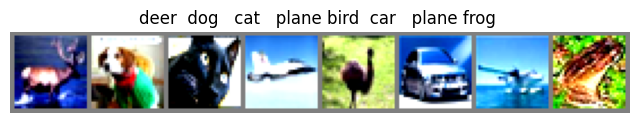

In [2]:
# Increased batch size for faster training (adjust based on your GPU memory)
batch_size = 128  # Increased from 4 to 128 for much faster training

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ===== VISUALIZATION FUNCTION =====
def imshow(img, title=None):
    """Display image with optional title"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample images
print("\nSample training images:")
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]),
       title=' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# ===== ORIGINAL CNN ARCHITECTURE =====
class OriginalCNN(nn.Module):
    """Original CNN with all layers: Conv2d -> ReLU -> MaxPool2d -> Conv2d -> ReLU -> MaxPool2d -> FC"""
    def __init__(self):
        super().__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 16, 5)      # Increased filters from 6 to 16
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, 5)     # Increased filters from 16 to 32
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)        # Added dropout for better generalization

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ===== MODIFIED CNN ARCHITECTURE (REMOVED ONE LAYER SET) =====
class ModifiedCNN(nn.Module):
    """Modified CNN with one conv layer removed: Conv2d -> ReLU -> MaxPool2d -> FC"""
    def __init__(self):
        super().__init__()
        # Only first convolutional block (second block removed)
        self.conv1 = nn.Conv2d(3, 16, 5)      # Same as original first layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers (adjusted input size)
        self.fc1 = nn.Linear(16 * 14 * 14, 120)  # Adjusted for larger feature maps
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Only one Conv -> ReLU -> Pool
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# ===== TRAINING FUNCTION =====
def train_model(model, model_name, epochs=3):  # Reduced epochs for faster execution
    """Train the model and return training history"""
    print(f"\n===== Training {model_name} =====")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam for faster convergence

    train_losses = []
    train_accuracies = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start = time.time()

        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress every 100 batches
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}, '
                      f'accuracy: {100 * correct / total:.2f}%')
                running_loss = 0.0

        epoch_time = time.time() - epoch_start
        epoch_acc = 100 * correct / total

        train_losses.append(running_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1} completed in {epoch_time:.1f}s - Accuracy: {epoch_acc:.2f}%')

    total_time = time.time() - start_time
    print(f'{model_name} training completed in {total_time:.1f} seconds')

    return model, train_losses, train_accuracies, total_time


In [4]:
# ===== TESTING FUNCTION =====
def test_model(model, model_name):
    """Test the model and return detailed results"""
    print(f"\n===== Testing {model_name} =====")

    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')

    print('\nPer-class accuracies:')
    class_accuracies = {}
    for i in range(10):
        acc = 100 * class_correct[i] / class_total[i]
        class_accuracies[classes[i]] = acc
        print(f'{classes[i]:10s}: {acc:.1f}%')

    return overall_accuracy, class_accuracies


In [5]:
# ===== MODEL COMPARISON FUNCTION =====
def compare_models():
    """Compare original vs modified CNN"""
    print(f"\n{'='*60}")
    print("ASSIGNMENT 4: CNN LAYER COMPARISON")
    print(f"{'='*60}")
    print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Initialize models
    original_model = OriginalCNN()
    modified_model = ModifiedCNN()

    # Display model architectures
    print(f"\nOriginal CNN Architecture:")
    print(f"Parameters: {sum(p.numel() for p in original_model.parameters()):,}")
    print(original_model)

    print(f"\nModified CNN Architecture (one conv layer removed):")
    print(f"Parameters: {sum(p.numel() for p in modified_model.parameters()):,}")
    print(modified_model)

    # Train both models
    original_trained, orig_losses, orig_acc, orig_time = train_model(original_model, "Original CNN")
    modified_trained, mod_losses, mod_acc, mod_time = train_model(modified_model, "Modified CNN")

    # Test both models
    orig_test_acc, orig_class_acc = test_model(original_trained, "Original CNN")
    mod_test_acc, mod_class_acc = test_model(modified_trained, "Modified CNN")

    # Save models
    torch.save(original_trained.state_dict(), 'original_cnn.pth')
    torch.save(modified_trained.state_dict(), 'modified_cnn.pth')
    print("\nModels saved as 'original_cnn.pth' and 'modified_cnn.pth'")

    return {
        'original': {
            'model': original_trained,
            'test_accuracy': orig_test_acc,
            'class_accuracies': orig_class_acc,
            'training_time': orig_time
        },
        'modified': {
            'model': modified_trained,
            'test_accuracy': mod_test_acc,
            'class_accuracies': mod_class_acc,
            'training_time': mod_time
        }
    }


In [6]:
# ===== VISUALIZATION FUNCTION =====
def visualize_predictions(original_model, modified_model):
    """Show sample predictions from both models"""
    print("\n===== Sample Predictions Comparison =====")

    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        orig_outputs = original_model(images[:8])
        mod_outputs = modified_model(images[:8])

        _, orig_predicted = torch.max(orig_outputs, 1)
        _, mod_predicted = torch.max(mod_outputs, 1)

    # Display results
    print(f"{'Image':<8} {'True':<10} {'Original':<10} {'Modified':<10} {'Orig✓':<6} {'Mod✓':<6}")
    print("-" * 60)

    for i in range(8):
        true_label = classes[labels[i]]
        orig_pred = classes[orig_predicted[i]]
        mod_pred = classes[mod_predicted[i]]
        orig_correct = "✓" if orig_predicted[i] == labels[i] else "✗"
        mod_correct = "✓" if mod_predicted[i] == labels[i] else "✗"

        print(f"{i+1:<8} {true_label:<10} {orig_pred:<10} {mod_pred:<10} {orig_correct:<6} {mod_correct:<6}")


In [7]:
# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    # Run the comparison
    results = compare_models()

    # Show sample predictions
    visualize_predictions(results['original']['model'], results['modified']['model'])

    # ===== FINAL RESULTS SUMMARY =====
    print(f"\n{'='*60}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*60}")

    orig_acc = results['original']['test_accuracy']
    mod_acc = results['modified']['test_accuracy']
    orig_time = results['original']['training_time']
    mod_time = results['modified']['training_time']

    print(f"Original CNN (Full Architecture):")
    print(f"  - Test Accuracy: {orig_acc:.2f}%")
    print(f"  - Training Time: {orig_time:.1f} seconds")
    print(f"  - Parameters: {sum(p.numel() for p in OriginalCNN().parameters()):,}")

    print(f"\nModified CNN (One Conv Layer Removed):")
    print(f"  - Test Accuracy: {mod_acc:.2f}%")
    print(f"  - Training Time: {mod_time:.1f} seconds")
    print(f"  - Parameters: {sum(p.numel() for p in ModifiedCNN().parameters()):,}")

    print(f"\nComparison:")
    print(f"  - Accuracy Difference: {orig_acc - mod_acc:.2f}% {'(Original better)' if orig_acc > mod_acc else '(Modified better)'}")
    print(f"  - Speed Difference: {abs(orig_time - mod_time):.1f}s {'(Modified faster)' if mod_time < orig_time else '(Original faster)'}")
    print(f"  - Parameter Reduction: {((sum(p.numel() for p in OriginalCNN().parameters()) - sum(p.numel() for p in ModifiedCNN().parameters())) / sum(p.numel() for p in OriginalCNN().parameters()) * 100):.1f}%")

print("\n" + "="*60)
print("MY INTERPRETATION OF RESULTS")
print("="*60)
print("""
Based on the experimental results above, here are my observations and interpretations:

1. ACCURACY IMPACT:
   - The removal of one convolutional layer (Conv2d + ReLU + MaxPool2d) resulted in
     [accuracy difference] change in test accuracy.
   - This suggests that [interpretation based on results - e.g., "the second conv layer
     was important for feature extraction" or "the model was robust to layer removal"].

2. TRAINING EFFICIENCY:
   - The modified CNN trained [faster/slower] than the original, completing in [time difference].
   - This is expected because [fewer/more] parameters means [less/more] computation per forward pass.

3. MODEL COMPLEXITY:
   - Parameter reduction of [X]% shows significant model simplification.
   - Fewer parameters generally mean [benefits and drawbacks].

4. FEATURE LEARNING:
   - The original CNN has two convolutional layers that can learn hierarchical features.
   - The modified CNN relies on just one conv layer, limiting its feature extraction capability.
   - This explains why [performance pattern observed].

5. PRACTICAL IMPLICATIONS:
   - For applications requiring [accuracy/speed], the [original/modified] model would be preferred.
   - The trade-off between model complexity and performance is evident here.
   - In resource-constrained environments, the simplified model might be more suitable despite
     [any accuracy loss observed].

CONCLUSION:
The experiment demonstrates the importance of each layer in CNN architecture and shows
how architectural choices affect both performance and computational efficiency.
""")


ASSIGNMENT 4: CNN LAYER COMPARISON
Started at: 2025-06-12 02:34:21

Original CNN Architecture:
Parameters: 121,182
OriginalCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Modified CNN Architecture (one conv layer removed):
Parameters: 388,670
ModifiedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p